# Predicitive Modeling:

In [1]:
#import necessary basic packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import Sklearn ML models and metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV


In [3]:
#importing encoded ML ready data
ML_data = pd.read_csv('data/ML_ready_train')

In [4]:
#creating features dataframe and 2 target arrays
Xs = ML_data.drop(columns=['respondent_id','seasonal_vaccine', 'h1n1_vaccine'])
Xh = ML_data.drop(columns=['respondent_id','h1n1_vaccine'])
yh = ML_data.h1n1_vaccine
ys = ML_data.seasonal_vaccine

In [197]:
#for contest fit
XH = Xh.drop(columns=['seasonal_vaccine'])
XH['seasonal_vaccine'] = ys

Here I decided to use H1N1 vaccination prediction as something we can use as a model of novel vaccines as new viruses and pandemics arise (cheifly the COVID19 pandemic). I will therefore be able to use the seasonal_vaccine as an additional feature in predicting H1N1 vaccination status. In the future we will have this data as seasonal flu vaccinations are recorded in state and federal databases or can be self declared by those answering survey questions. Using H1N1 vaccination status to predict seasonal vaccination is less useful because the H1N1 vaccine was only given one year, whereas seasonal flu vaccines are given every year. Also it is more important to be able to use this information to predict who will get vaccinations for novel viruses during a pandemic.

# Splitting the Data into Train and Test Sets:

Because we have 2 variables we are interested in predicting for, I need a train/test split for each one

## H1N1 Train/Test Split:

In [5]:
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh, yh, test_size=0.3, random_state=49)

## Seasonal Train/Test Split:

In [13]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.3, random_state=42)

# Random Forest Classifier:

Using cross validation we can use the train data to find the optimal hyperparameter values. Here I decided to compare some of the more important hyperparameters, leaving out n_estimators. n_estimators can be optimized afterward as including it in the GridSearchCV took much too long.

### Seasonal RF Model Tuning:

In [15]:
RF = RandomForestClassifier()

params = {'criterion': ['entropy', 'gini'], 'min_samples_leaf':[2,3,4,5,6]}

GS_rfc = GridSearchCV(estimator=RF, param_grid=params, scoring='roc_auc', verbose=True)
 
GS_rfc.fit(Xs_train, ys_train)


print(GS_rfc.best_estimator_) 
print(GS_rfc.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(criterion='entropy', min_samples_leaf=4)
0.8549371935774108


In [9]:
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=4)
params = {'n_estimators': [100, 500, 2000, 10000]}
GS2_rfc = GridSearchCV(estimator=RF, param_grid=params, scoring='roc_auc', verbose=True)

GS2_rfc.fit(Xs_train, ys_train)

print(GS2_rfc.best_estimator_) 
print(GS2_rfc.cv_results_['mean_test_score'])
print(GS2_rfc.cv_results_['mean_fit_time'])


Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       n_estimators=10000)
[0.85420909 0.85614868 0.85625279 0.85642956]
[  1.97256904   9.65757461  38.66250281 196.02949681]


### H1N1 RF Model Tuning:

In [16]:
RF = RandomForestClassifier()

params = {'criterion': ['entropy', 'gini'], 'min_samples_leaf':[2,3,4,5,6]}

GS_rfc2 = GridSearchCV(estimator=RF, param_grid=params, scoring='roc_auc')

GS_rfc2.fit(Xh_train, yh_train)


print(GS_rfc2.best_estimator_) 
print(GS_rfc2.best_score_)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3)
0.8912952122907403


In [11]:
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=4)
params = {'n_estimators': [100, 200, 500, 1000, 2000]}
GS2_rfc2 = GridSearchCV(estimator=RF, param_grid=params, scoring='roc_auc', verbose=True)

GS2_rfc2.fit(Xh_train, yh_train)

print(GS2_rfc2.best_estimator_) 
print(GS2_rfc2.cv_results_['mean_test_score'])
print(GS2_rfc2.cv_results_['mean_fit_time'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       n_estimators=2000)
[0.88877109 0.89037219 0.89036125 0.89090145 0.89102526]
[ 1.88479457  3.42517099  9.24269323 17.24626627 35.1677516 ]


## Seasonal Random Forest Model:

In [147]:
%%time
rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_leaf=4, n_estimators = 500)
rfc.fit(Xs_train, ys_train)

ys_pred_rfc = rfc.predict(Xs_test)
rfc_s_proba = rfc.predict_proba(Xs_test)

Accuracy_rfc = rfc.score(Xs_test,ys_test)
print(Accuracy_rfc)

0.7888431299138899
CPU times: user 15.2 s, sys: 302 ms, total: 15.5 s
Wall time: 15.7 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



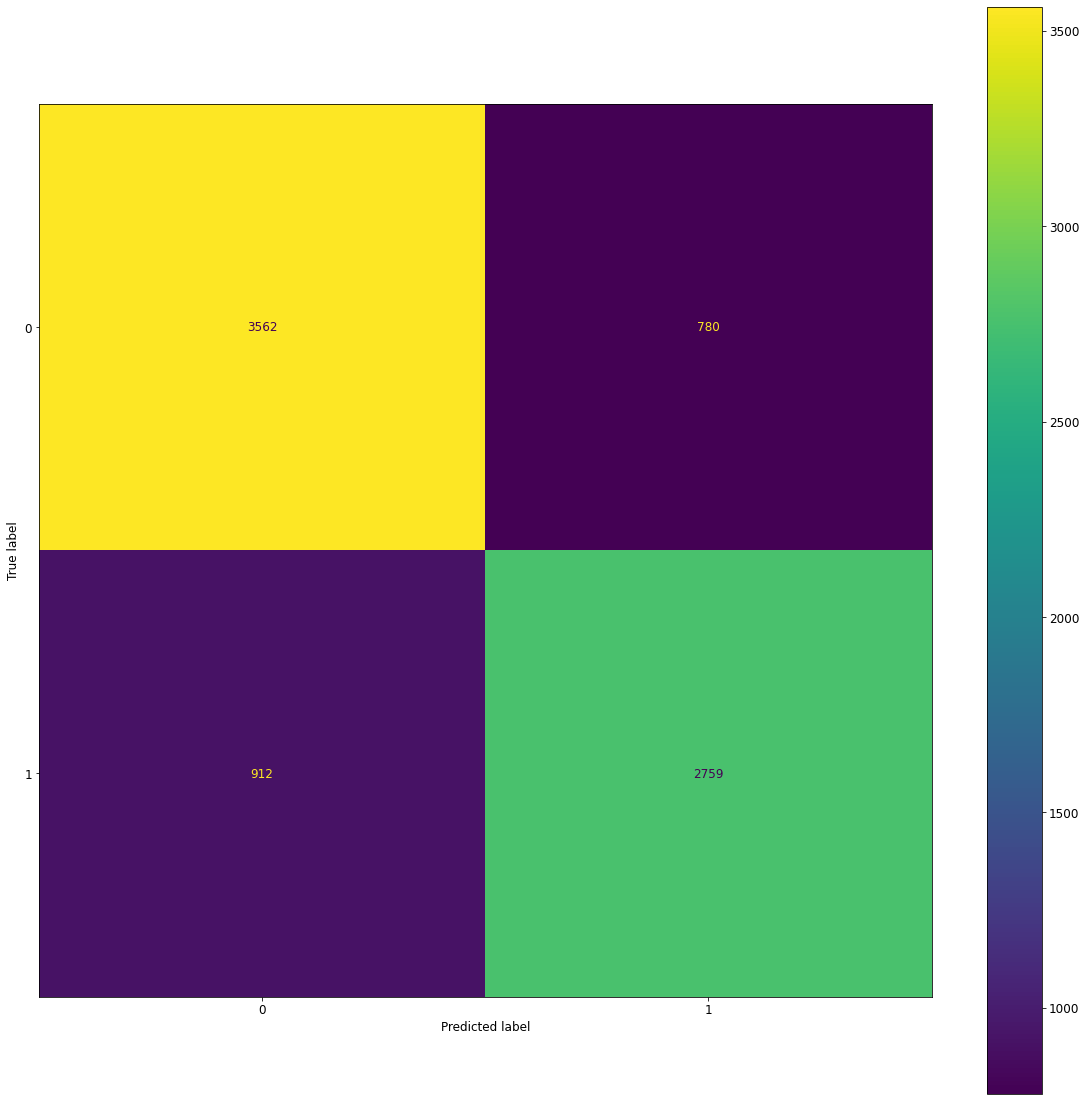

In [148]:
plot_confusion_matrix(rfc,Xs_test,ys_test);

In [149]:
print(classification_report(ys_test, ys_pred_rfc))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4342
           1       0.78      0.75      0.77      3671

    accuracy                           0.79      8013
   macro avg       0.79      0.79      0.79      8013
weighted avg       0.79      0.79      0.79      8013



In [150]:
roc_auc_score(ys_test, rfc_s_proba[:,1])

0.8614955617754707

### Cross Validated Accuracy and ROC_AUC:

In [151]:
cv_scores_test= cross_val_score(rfc,Xs_test,ys_test,cv=5)
cv_scores_train= cross_val_score(rfc,Xs_train,ys_train,cv=5)
print(cv_scores_test)
cv_scores_rfs_test= cv_scores_test.mean()
cv_scores_rfs_train= cv_scores_train.mean()
cv_scores_std_rfs= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfs_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfs_train))
print ('Standard deviation in cv score: ' +str(cv_scores_std_rfs))

[0.80536494 0.78477854 0.7654398  0.77091136 0.78776529]
Mean cross validation test score: 0.7828519871059492
Mean cross validation train score: 0.7791271017062928
Standard deviation in cv score: 0.014003200134797878


In [152]:
cv_scores_test= cross_val_score(rfc,Xs_test,ys_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rfc,Xs_train,ys_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_rocauc_rfs_test= cv_scores_test.mean()
cv_rocauc_rfs_train= cv_scores_train.mean()
cv_rocauc_std_rfs= cv_scores_test.std()
print ('Mean cross validation test ROC_AUC: ' +str(cv_rocauc_rfs_test))
print ('Mean cross validation train ROC_AUC: ' +str(cv_rocauc_rfs_train))
print ('Standard deviation in cv ROC_AUC: ' +str(cv_rocauc_std_rfs))

[0.86322561 0.85671777 0.84649205 0.85733278 0.86068541]
Mean cross validation test ROC_AUC: 0.8568907213999977
Mean cross validation train ROC_AUC: 0.8560680182840311
Standard deviation in cv ROC_AUC: 0.005707679421740283


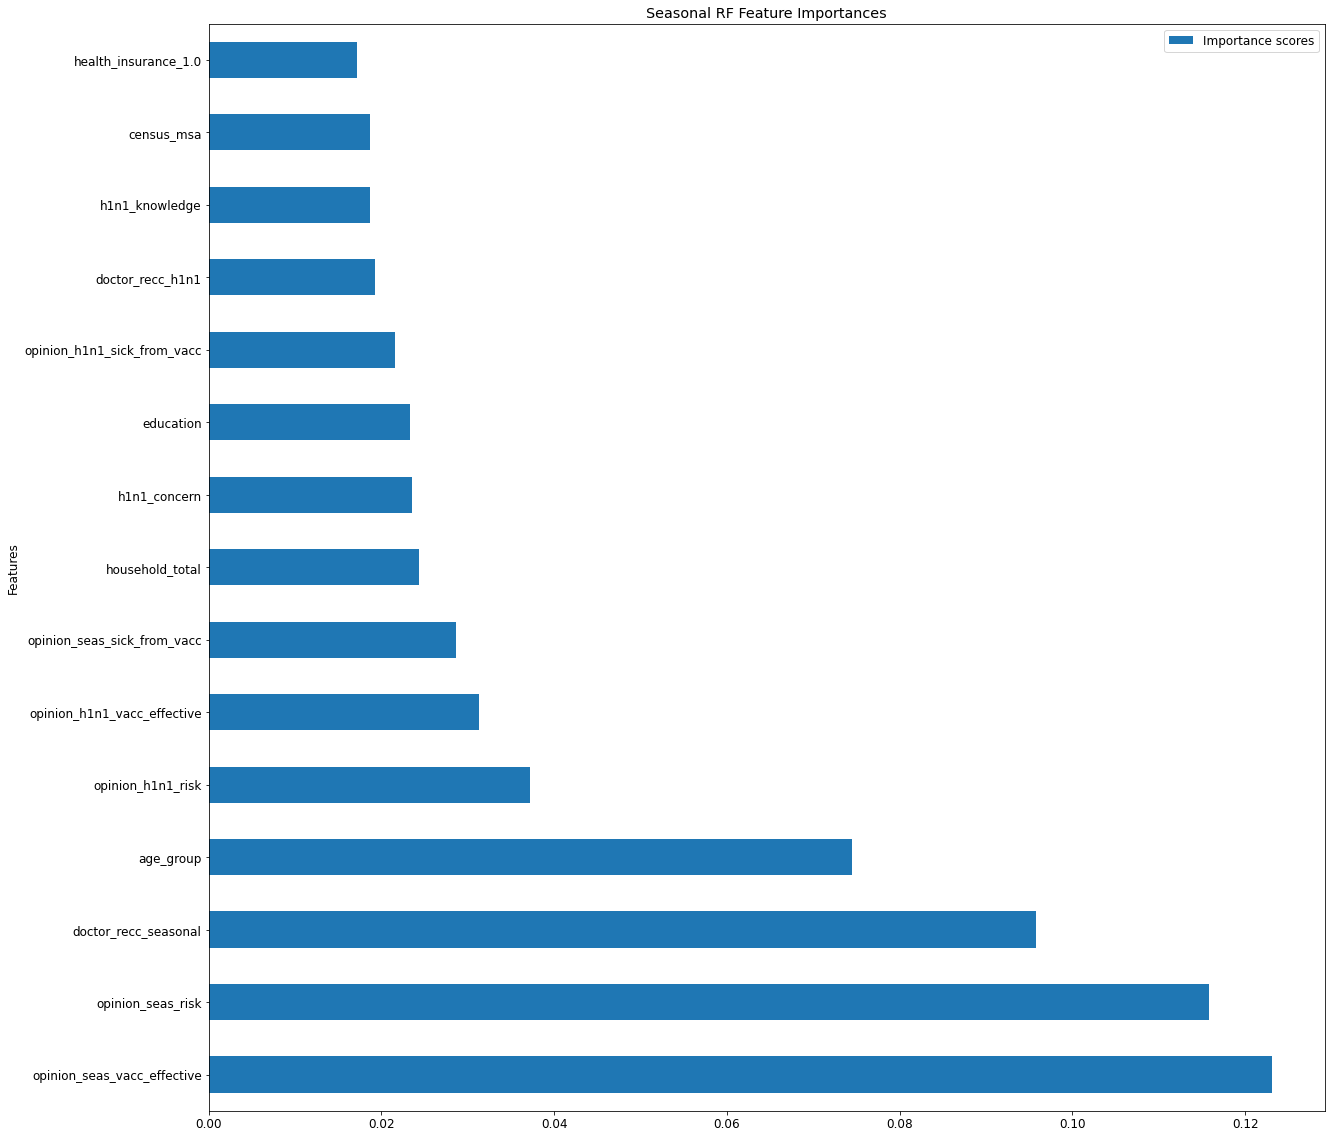

In [153]:
importances = list(rfc.feature_importances_)

tab=pd.DataFrame(list(zip(Xs,importances)),columns =['Features', 'Importance scores']) 
imp = tab.sort_values(by='Importance scores', ascending=False)

imp[:15].plot(kind='barh', x='Features')
plt.title('Seasonal RF Feature Importances')
plt.savefig('./figures/RFC_seas_FI.pdf');

### H1N1 Random Forest Model:

In [154]:
%%time
rfc2 = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_leaf=3, n_estimators=500)
rfc2.fit(Xh_train, yh_train)

yh_pred_rfc = rfc2.predict(Xh_test)
rfc_h_proba = rfc2.predict_proba(Xh_test)

Accuracy_rfc2 = rfc2.score(Xh_test,yh_test)
print(Accuracy_rfc2)

0.865967802321228
CPU times: user 14.4 s, sys: 211 ms, total: 14.6 s
Wall time: 14.7 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



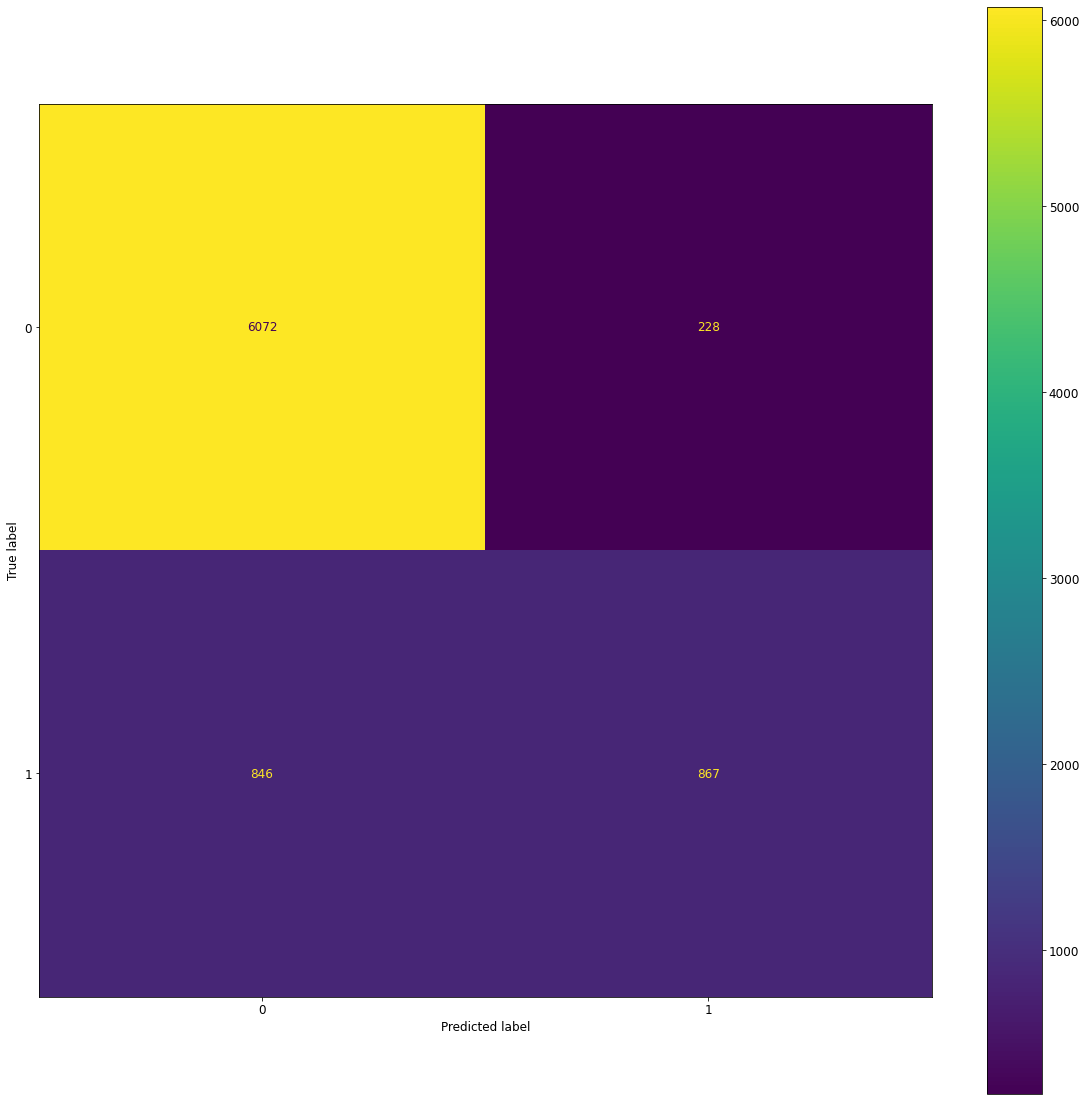

In [155]:
plot_confusion_matrix(rfc2,Xh_test,yh_test);

In [156]:
print(classification_report(yh_test, yh_pred_rfc))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6300
           1       0.79      0.51      0.62      1713

    accuracy                           0.87      8013
   macro avg       0.83      0.73      0.77      8013
weighted avg       0.86      0.87      0.85      8013



In [157]:
roc_auc_score(yh_test, rfc_h_proba[:,1])

0.8906496539070969

### H1N1 Cross Validated Accuracy and ROC_AUC:

In [158]:
cv_scores_test= cross_val_score(rfc2,Xh_test,yh_test,cv=5)
cv_scores_train= cross_val_score(rfc2,Xh_train,yh_train,cv=5)
print(cv_scores_test)
cv_scores_rfh_test= cv_scores_test.mean()
cv_scores_rfh_train= cv_scores_train.mean()
cv_scores_std_rfh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfh_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfh_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rfh))

[0.85901435 0.86088584 0.87398628 0.86142322 0.85580524]
Mean cross validation test score: 0.8622229854603143
Mean cross validation train score: 0.8645553477287612
Standard deviation in cv scores: 0.006201376429224566


In [159]:
cv_scores_test= cross_val_score(rfc2,Xh_test,yh_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rfc2,Xh_train,yh_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_rocauc_rfh_test= cv_scores_test.mean()
cv_rocauc_rfh_train= cv_scores_train.mean()
cv_rocauc_std_rfh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_rocauc_rfh_test))
print ('Mean cross validation train score: ' +str(cv_rocauc_rfh_train))
print ('Standard deviation in cv scores: ' +str(cv_rocauc_std_rfh))

[0.88923134 0.88168356 0.89160304 0.87551286 0.88632229]
Mean cross validation test score: 0.8848706151514192
Mean cross validation train score: 0.8926812099410222
Standard deviation in cv scores: 0.005730161199559213


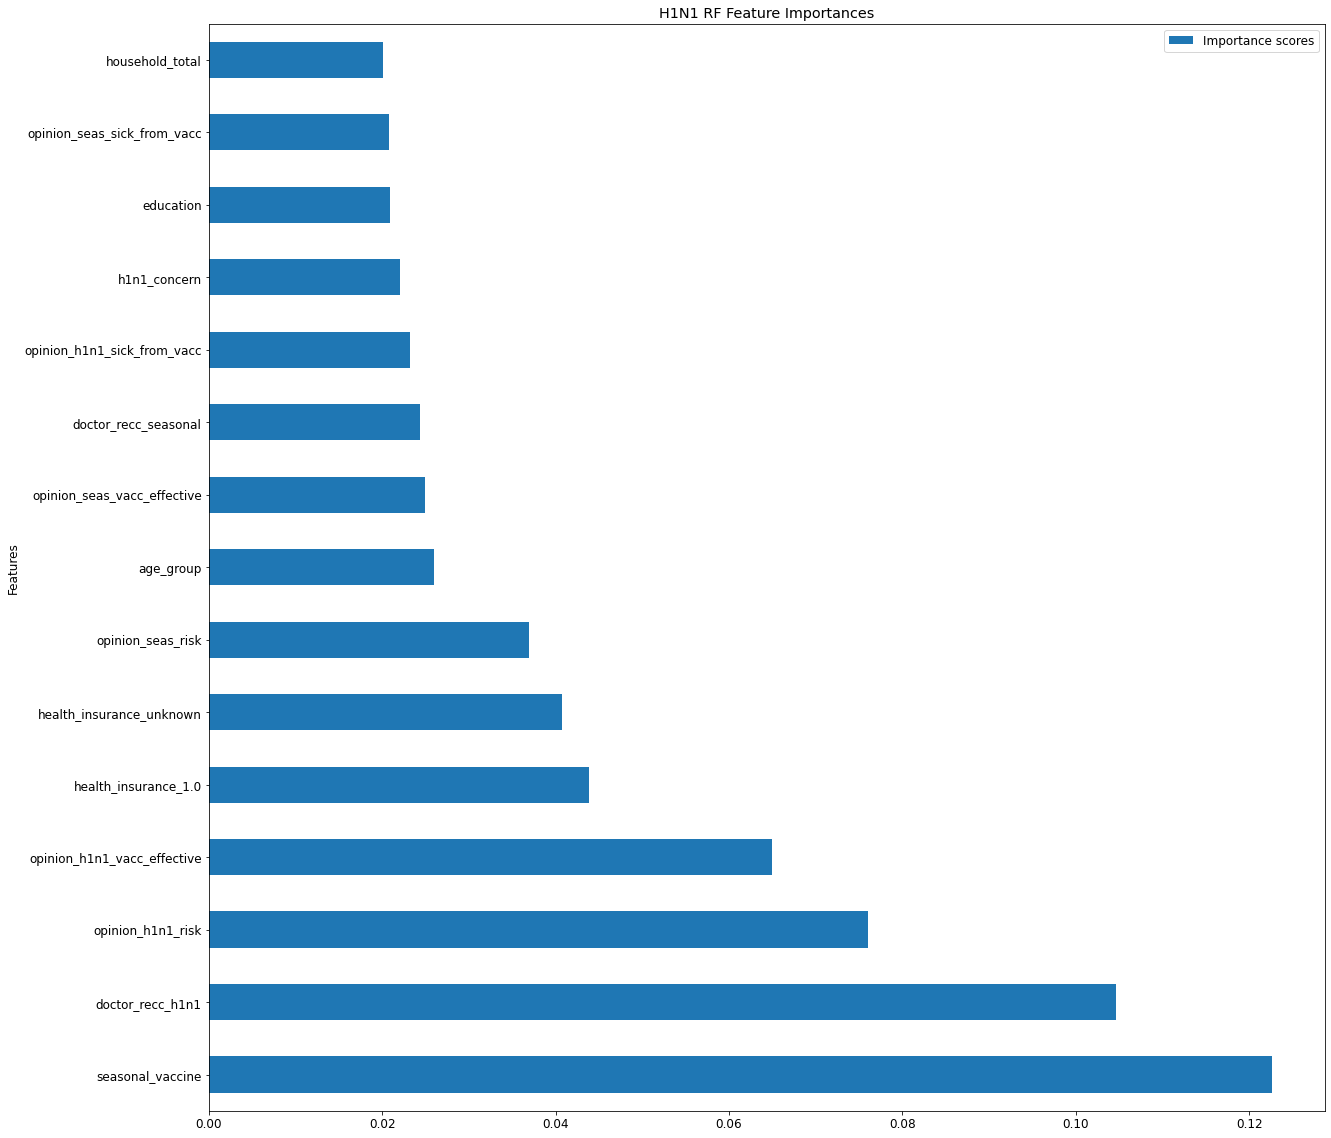

In [160]:
importances = list(rfc2.feature_importances_)

tab=pd.DataFrame(list(zip(Xh,importances)),columns =['Features', 'Importance scores']) 
imp = tab.sort_values(by='Importance scores', ascending=False)


imp[:15].plot(kind='barh', x='Features')
plt.title('H1N1 RF Feature Importances')
plt.savefig('./figures/RFC_H1N1_FI.pdf');

# Logistic Regression:

## Scaling Data:

Although this data is all relatively similar in scale, Logistic Regression will operate best with all features being of the same scale. Here I used MinMaxScaler to put all variables between 0 and 1.

In [47]:
scaler = MinMaxScaler()
scaler.fit(Xs)
scaled_s = scaler.transform(Xs)

In [48]:
scaler = MinMaxScaler()
scaler.fit(Xh)
scaled_h = scaler.transform(Xh)

In [49]:
X2h_train, X2h_test, y2h_train, y2h_test = train_test_split(scaled_h, yh, test_size=0.3, random_state=49)
X2s_train, X2s_test, y2s_train, y2s_test = train_test_split(scaled_s, ys, test_size=0.3, random_state=49)

### Cross Validating Hyperparameters
Cross validation used again to find the optimal hyperparameters for a logistic regression model. At the default max_iter of 100, many of the models were not converging and unable to determine which hyperparameters were best. So by increasing max_iter to 5000 in grid search, I was able to see every combination of hyperparameters.

In [50]:
LR = LogisticRegression(max_iter=5000)

params = {
    'penalty' : [None, 'l1','l2', 'elasticnet'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

GS_lr1 = GridSearchCV(estimator=LR, param_grid=params, scoring='roc_auc')

GS_lr1.fit(X2s_train, y2s_train)


print(GS_lr1.best_estimator_) 
print(GS_lr1.best_score_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
455 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 441, in _check_solver
    raise ValueError(
V

LogisticRegression(max_iter=5000, penalty='l1', solver='liblinear')
0.852381963066485


In [51]:
LR = LogisticRegression(max_iter=5000)

params = {
    'penalty' : [None, 'l1','l2', 'elasticnet'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


GS_lr2 = GridSearchCV(estimator=LR, param_grid=params, scoring='roc_auc')

GS_lr2.fit(X2h_train, y2h_train)


print(GS_lr2.best_estimator_) 
print(GS_lr2.best_score_)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
455 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 441, in _check_solver
    raise ValueError(
V

LogisticRegression(max_iter=5000, penalty='l1', solver='liblinear')
0.8889017918668634


### Seasonal LR Model:

In [114]:
%%time
Logreg = LogisticRegression(max_iter=5000, penalty='l1', solver='saga', random_state=49)
Logreg.fit(X2s_train,y2s_train)
    
ys_pred_lr = Logreg.predict(X2s_test)
lr_s_proba = Logreg.predict_proba(X2s_test)
    
print(Logreg.score(X2s_test, y2s_test))

0.7848496193685262
CPU times: user 1.52 s, sys: 19.9 ms, total: 1.54 s
Wall time: 1.57 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



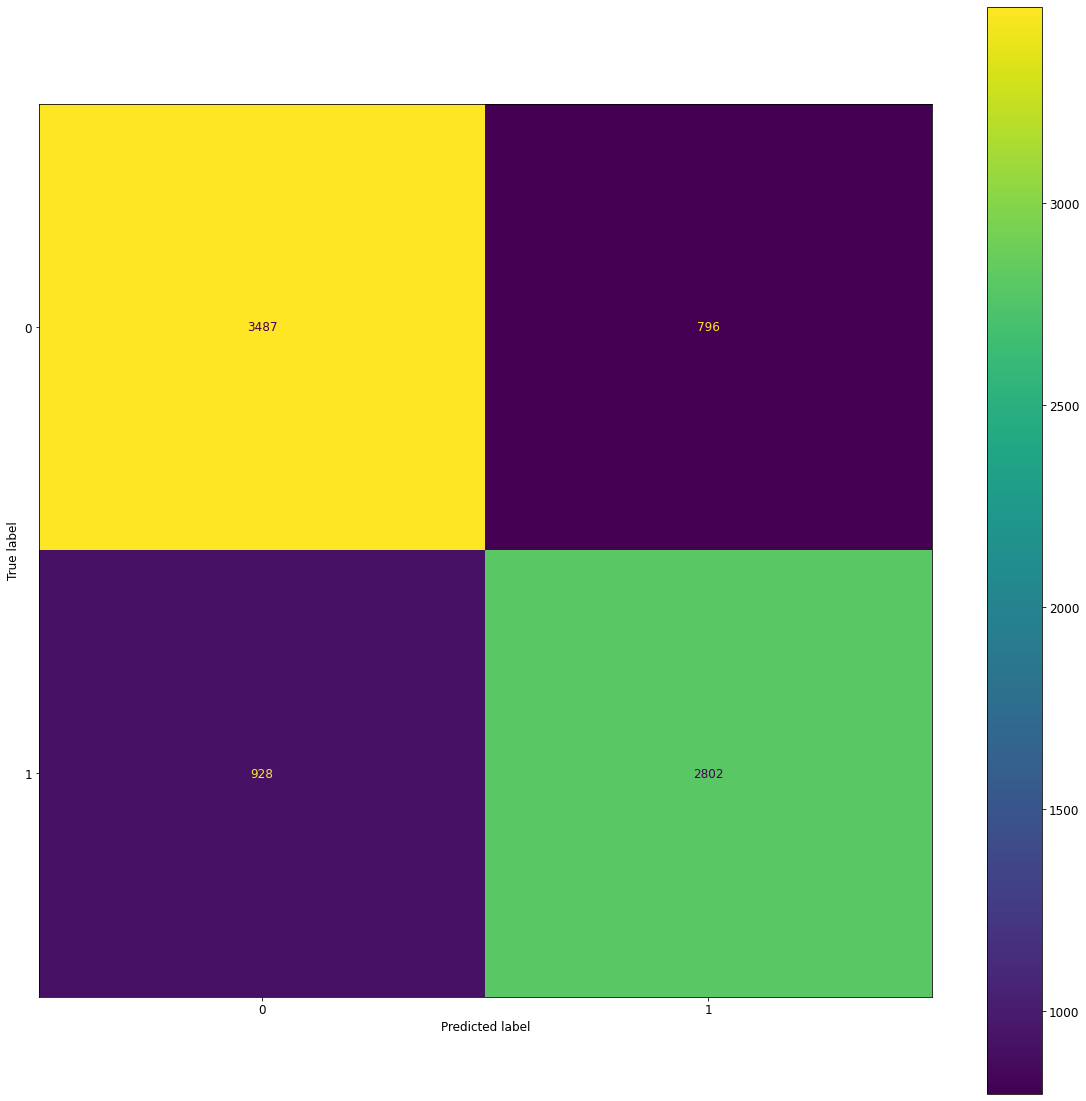

In [115]:
plot_confusion_matrix(Logreg,X2s_test,y2s_test);

In [116]:
print(classification_report(y2s_test, ys_pred_lr))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4283
           1       0.78      0.75      0.76      3730

    accuracy                           0.78      8013
   macro avg       0.78      0.78      0.78      8013
weighted avg       0.78      0.78      0.78      8013



In [117]:
roc_auc_score(y2s_test, lr_s_proba[:,1])

0.8566603173967285

### Cross Validated Accuracy and ROC_AUC:

In [118]:
cv_scores_test= cross_val_score(Logreg,X2s_test,y2s_test,cv=5)
cv_scores_train= cross_val_score(Logreg,X2s_train,y2s_train,cv=5)
print(cv_scores_test)
cv_scores_lrs_test= cv_scores_test.mean()
cv_scores_lrs_train= cv_scores_train.mean()
cv_scores_std_lrs= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lrs_test))
print ('Mean cross validation train score: ' +str(cv_scores_lrs_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_lrs))

[0.79039301 0.78041173 0.78727386 0.77777778 0.7690387 ]
Mean cross validation test score: 0.7809790164041672
Mean cross validation train score: 0.7780568104105913
Standard deviation in cv scores: 0.007501856712027338


In [119]:
cv_scores_test= cross_val_score(Logreg,X2s_test,y2s_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X2s_train,y2s_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_rocauc_lrs_test= cv_scores_test.mean()
cv_rocauc_lrs_train= cv_scores_train.mean()
cv_rocauc_std_lrs= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_rocauc_lrs_test))
print ('Mean cross validation train score: ' +str(cv_rocauc_lrs_train))
print ('Standard deviation in cv scores: ' +str(cv_rocauc_std_lrs))

[0.86507894 0.85754909 0.86136094 0.84764539 0.84556106]
Mean cross validation test score: 0.8554390845330977
Mean cross validation train score: 0.8523809883738922
Standard deviation in cv scores: 0.007625804620717363


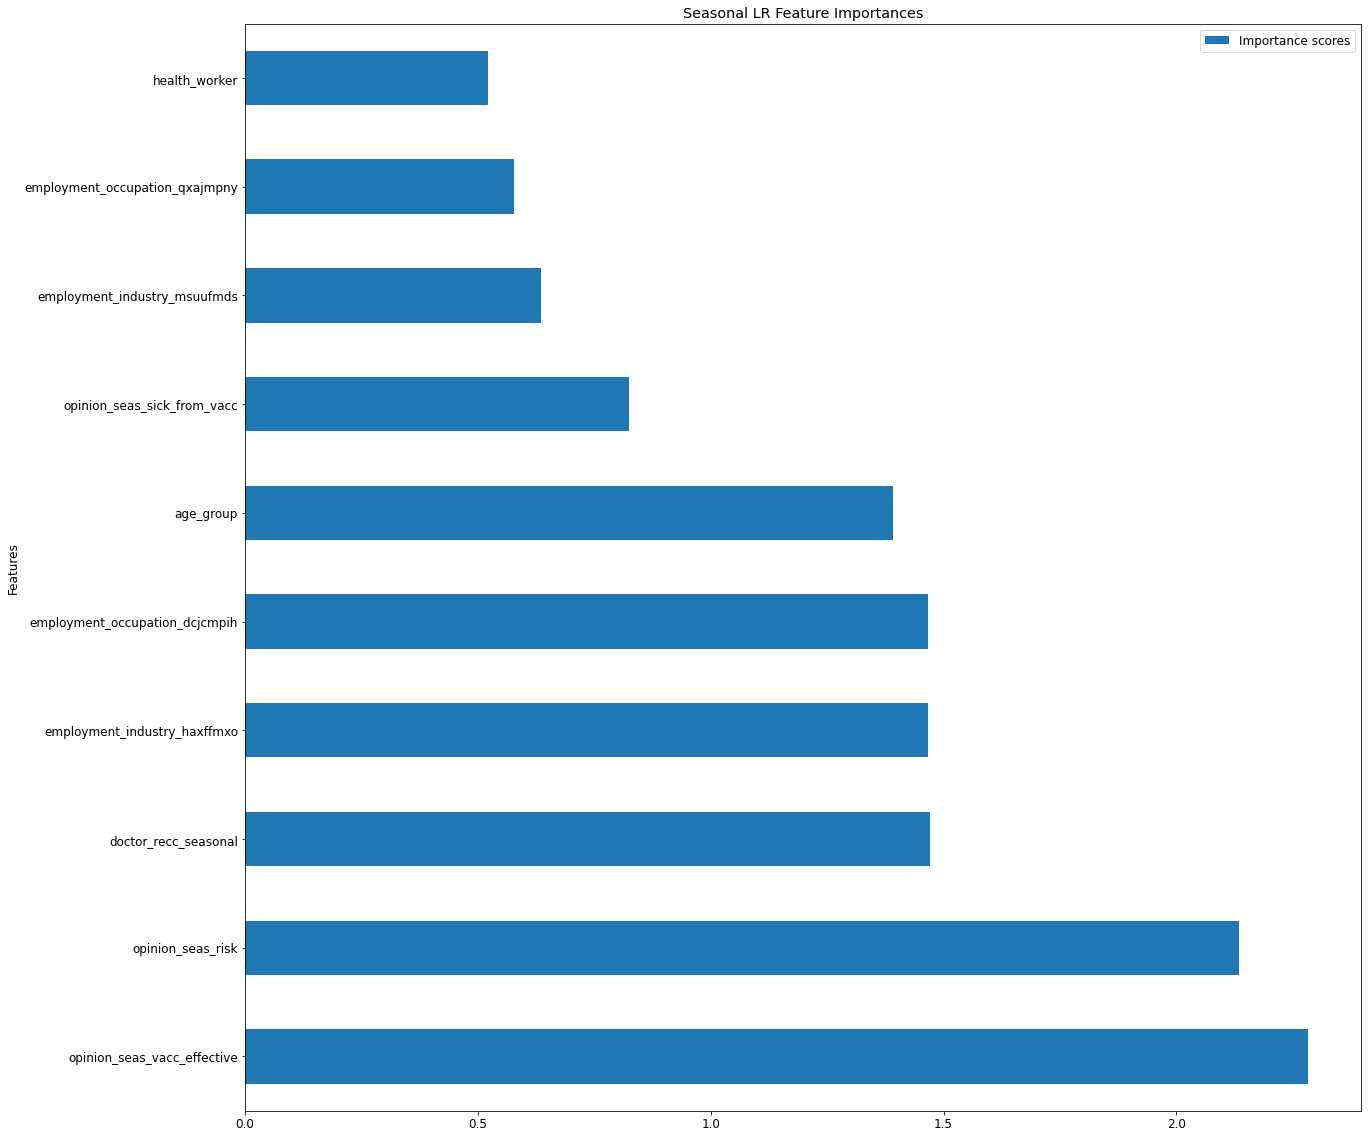

In [120]:
importances = list(abs(Logreg.coef_[0]))

tab=pd.DataFrame(list(zip(Xs,importances)),columns =['Features', 'Importance scores']) 
imp = tab.sort_values(by='Importance scores', ascending=False)

imp[:10].plot(kind='barh', x='Features')
plt.title('Seasonal LR Feature Importances')
plt.savefig('./figures/LR_seas_FI.pdf');

### H1N1 LR Model:

In [121]:
%%time
Logreg2 = LogisticRegression(max_iter=5000, penalty='l1', solver='liblinear', random_state=49)
Logreg2.fit(X2h_train,y2h_train)
    
yh_pred_lr = Logreg2.predict(X2h_test)
lr_h_proba = Logreg2.predict_proba(X2h_test)

    
print(Logreg2.score(X2h_test, y2h_test))

0.8645950330712592
CPU times: user 5.01 s, sys: 33.5 ms, total: 5.04 s
Wall time: 5.08 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



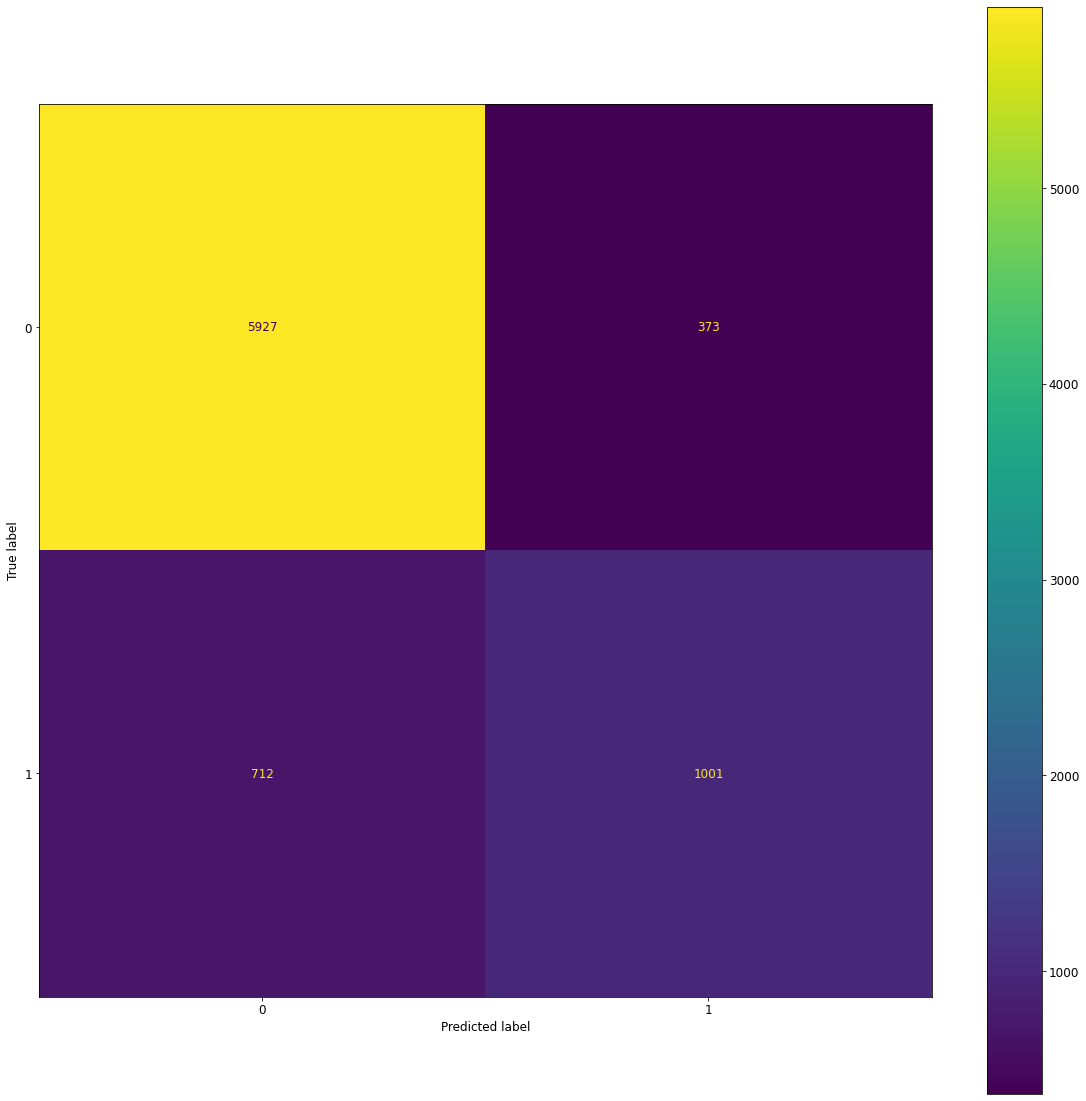

In [122]:
plot_confusion_matrix(Logreg2,X2h_test,y2h_test);

In [123]:
print(classification_report(y2h_test, yh_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6300
           1       0.73      0.58      0.65      1713

    accuracy                           0.86      8013
   macro avg       0.81      0.76      0.78      8013
weighted avg       0.86      0.86      0.86      8013



In [124]:
roc_auc_score(y2h_test, lr_h_proba[:,1])

0.8861993717510355

### H1N1 Cross Validated Accuracy and ROC_AUC:

In [125]:
cv_scores_test= cross_val_score(Logreg2,X2h_test,y2h_test,cv=5)
cv_scores_train= cross_val_score(Logreg2,X2h_train,y2h_train,cv=5)
print(cv_scores_test)
cv_scores_lrh_test= cv_scores_test.mean()
cv_scores_lrh_train= cv_scores_train.mean()
cv_scores_std_lrh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lrh_test))
print ('Mean cross validation train score: ' +str(cv_scores_lrh_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_lrh))

[0.85464754 0.86774797 0.87710543 0.85330836 0.8545568 ]
Mean cross validation test score: 0.8614732208569607
Mean cross validation train score: 0.865678571178149
Standard deviation in cv scores: 0.009432179644185005


In [126]:
cv_scores_test= cross_val_score(Logreg2,X2h_test,y2h_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg2,X2h_train,y2h_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_rocauc_lrh_test= cv_scores_test.mean()
cv_rocauc_lrh_train= cv_scores_train.mean()
cv_rocauc_std_lrh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_rocauc_lrh_test))
print ('Mean cross validation train score: ' +str(cv_rocauc_lrh_train))
print ('Standard deviation in cv scores: ' +str(cv_rocauc_std_lrh))

[0.89264427 0.88402517 0.89493035 0.87025202 0.87966676]
Mean cross validation test score: 0.8843037149617375
Mean cross validation train score: 0.8889016209048876
Standard deviation in cv scores: 0.00896124293554669


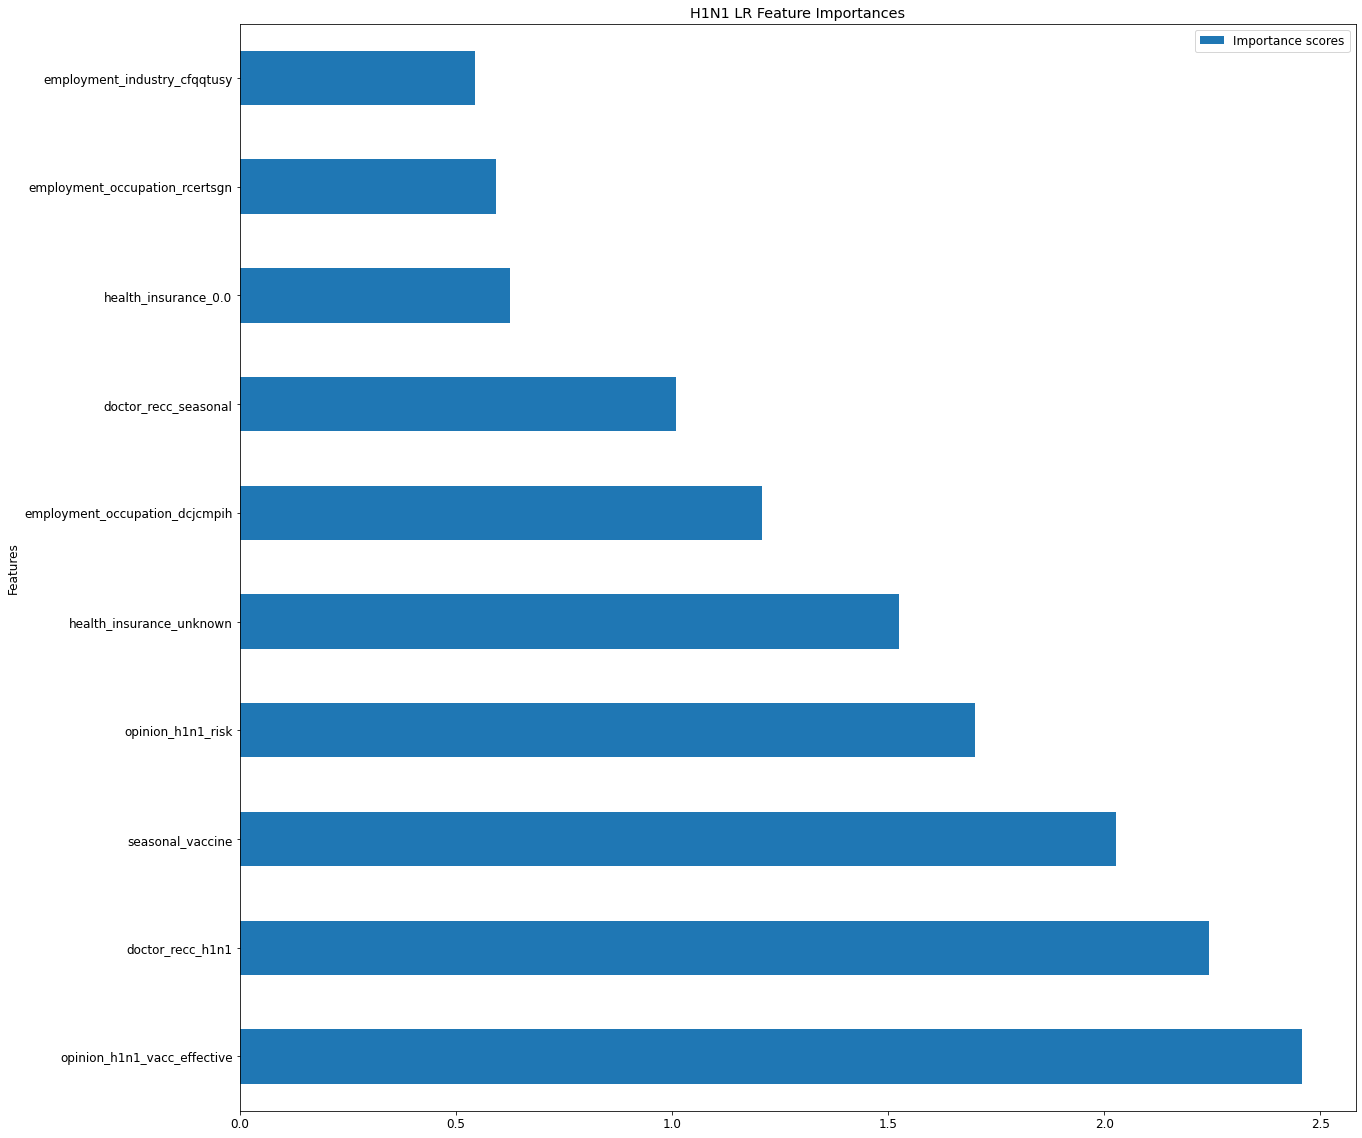

In [127]:
importances = list(abs(Logreg2.coef_[0]))

tab=pd.DataFrame(list(zip(Xh,importances)),columns =['Features', 'Importance scores']) 
imp = tab.sort_values(by='Importance scores', ascending=False)

imp[:10].plot(kind='barh', x='Features')
plt.title('H1N1 LR Feature Importances')
plt.savefig('./figures/LR_H1N1_FI.pdf');

# Gradient Boosting:

### GridSearchCV for Hyperparameter Tuning:

In [70]:
GBC = GradientBoostingClassifier()

params = {
    
    "learning_rate":  [.12, 0.15, 0.16],
    "min_samples_leaf": [10, 20, 30],
    "max_features": ['auto', 'log2', None]
    }

GS = GridSearchCV(estimator=GBC, param_grid=params, scoring='roc_auc')

GS.fit(Xs_train, ys_train)


print(GS.best_estimator_) 
print(GS.best_score_)

GradientBoostingClassifier(learning_rate=0.15, max_features='auto',
                           min_samples_leaf=20)
0.8608616781405111


In [77]:
GBC =  GradientBoostingClassifier()

params = {
    "learning_rate":  [.14,.15, .16],
    "min_samples_leaf": [9,10,11],
    "max_features": ['auto', 'log2', None]
    }

GS = GridSearchCV(estimator=GBC, param_grid=params, scoring='roc_auc')

GS.fit(Xh_train, yh_train)


print(GS.best_estimator_) 
print(GS.best_score_)

GradientBoostingClassifier(learning_rate=0.15, max_features='auto',
                           min_samples_leaf=10)
0.8967238601500146


### Seasonal Gradient Boosting Model:

In [72]:
%%time
gbc = GradientBoostingClassifier(learning_rate=0.15, max_features='auto',
                           min_samples_leaf=20, n_estimators=10000, n_iter_no_change=10, random_state=49)
gbc.fit(Xs_train, ys_train)


ys_predict_gbc = gbc.predict(Xs_test)
gbc_s_proba = gbc.predict_proba(Xs_test)

print(gbc.score(Xs_test,ys_test))


0.7928366404592537
CPU times: user 11.2 s, sys: 131 ms, total: 11.3 s
Wall time: 11.4 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


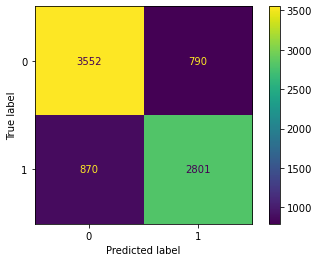

In [78]:
plot_confusion_matrix(gbc,Xs_test,ys_test);

In [79]:
print(classification_report(ys_test, ys_predict_gbc))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4342
           1       0.78      0.76      0.77      3671

    accuracy                           0.79      8013
   macro avg       0.79      0.79      0.79      8013
weighted avg       0.79      0.79      0.79      8013



In [80]:
roc_auc_score(ys_test, gbc_s_proba[:,1])

0.8648978053364595

### Seasonal Cross Validated Accuracy and ROC_AUC:

In [81]:
cv_scores_test= cross_val_score(gbc,Xs_test,ys_test,cv=5)
cv_scores_train= cross_val_score(gbc,Xs_train,ys_train,cv=5)
print(cv_scores_test)
cv_scores_gbs_test= cv_scores_test.mean()
cv_scores_gbs_train= cv_scores_train.mean()
cv_scores_std_gbs= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbs_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbs_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbs))

[0.79475983 0.79164067 0.76606363 0.77777778 0.78963795]
Mean cross validation test score: 0.7839759720187569
Mean cross validation train score: 0.7843698032867161
Standard deviation in cv scores: 0.010642995366821333


In [82]:
cv_scores_test= cross_val_score(gbc,Xs_test,ys_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc,Xs_train,ys_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_rocauc_gbs_test= cv_scores_test.mean()
cv_rocauc_gbs_train= cv_scores_train.mean()
cv_rocauc_std_gbs= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_rocauc_gbs_test))
print ('Mean cross validation train score: ' +str(cv_rocauc_gbs_train))
print ('Standard deviation in cv scores: ' +str(cv_rocauc_std_gbs))

[0.86644347 0.86630864 0.8489216  0.86095459 0.86109507]
Mean cross validation test score: 0.8607446715831415
Mean cross validation train score: 0.8600250795275768
Standard deviation in cv scores: 0.006377867315326156


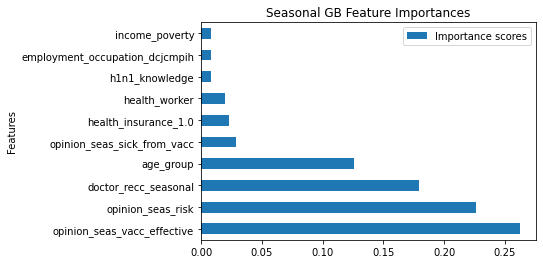

In [83]:
importances = list(gbc.feature_importances_)

tab=pd.DataFrame(list(zip(Xs,importances)),columns =['Features', 'Importance scores']) 
imp = tab.sort_values(by='Importance scores', ascending=False)

imp[:10].plot(kind='barh', x='Features')
plt.title('Seasonal GB Feature Importances')
plt.savefig('./figures/GBC_seas_FI.pdf');

### H1N1 Gradient Boosting Model:

In [86]:
%%time
gbc2 = GradientBoostingClassifier(learning_rate=0.15, max_features='auto', min_samples_leaf=10, n_estimators=10000,
                           n_iter_no_change=20, random_state = 42)

gbc2.fit(Xh_train, yh_train)


yh_predict_gbc = gbc2.predict(Xh_test)

gbc_h_proba = gbc2.predict_proba(Xh_test)


print(gbc2.score(Xh_test,yh_test))


0.8694621240484213
CPU times: user 6.63 s, sys: 100 ms, total: 6.73 s
Wall time: 7.02 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


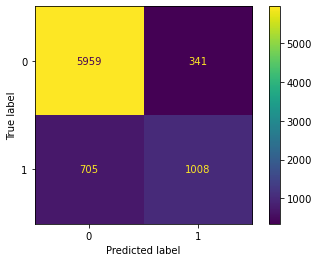

In [87]:
plot_confusion_matrix(gbc2,Xh_test,yh_test);

In [88]:
print(classification_report(yh_test, yh_predict_gbc))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6300
           1       0.75      0.59      0.66      1713

    accuracy                           0.87      8013
   macro avg       0.82      0.77      0.79      8013
weighted avg       0.86      0.87      0.86      8013



In [89]:
roc_auc_score(yh_test, gbc_h_proba[:,1])

0.8932891335168044

### H1N1 Cross Validated Accuracy and ROC_AUC:

In [90]:
cv_scores_test= cross_val_score(gbc2,Xh_test,yh_test,cv=5)
cv_scores_train= cross_val_score(gbc2,Xh_train,yh_train,cv=5)
print(cv_scores_test)
cv_scores_gbh_test= cv_scores_test.mean()
cv_scores_gbh_train= cv_scores_train.mean()
cv_scores_std_gbh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbh_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbh_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbh))

[0.86400499 0.86961946 0.87024329 0.86579276 0.86454432]
Mean cross validation test score: 0.8668409653248474
Mean cross validation train score: 0.8675509155373687
Standard deviation in cv scores: 0.0025966117050077514


In [91]:
cv_scores_test= cross_val_score(gbc2,Xh_test,yh_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc2,Xh_train,yh_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_rocauc_gbh_test= cv_scores_test.mean()
cv_rocauc_gbh_train= cv_scores_train.mean()
cv_rocauc_std_gbh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_rocauc_gbh_test))
print ('Mean cross validation train score: ' +str(cv_rocauc_gbh_train))
print ('Standard deviation in cv scores: ' +str(cv_rocauc_std_gbh))

[0.89482045 0.88658429 0.89328058 0.87887543 0.89051448]
Mean cross validation test score: 0.8888150452526954
Mean cross validation train score: 0.895441610288454
Standard deviation in cv scores: 0.005703790066480328


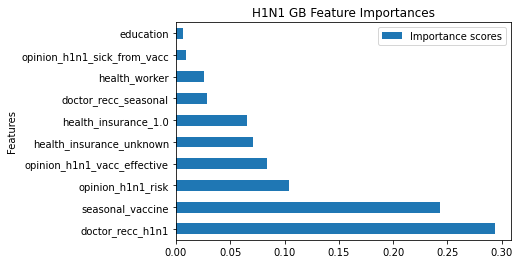

In [92]:
importances = list(gbc2.feature_importances_)

tab=pd.DataFrame(list(zip(Xh,importances)),columns =['Features', 'Importance scores']) 
imp = tab.sort_values(by='Importance scores', ascending=False)

imp[:10].plot(kind='barh', x='Features')
plt.title('H1N1 GB Feature Importances')
plt.savefig('./figures/GBC_H1N1_FI.pdf');

In [163]:
s_metric_dct = {'model': ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier'], 
                'accuracy': [cv_scores_lrs_test, cv_scores_rfs_test, cv_scores_gbs_test], 
                'ROC_AUC': [cv_rocauc_lrs_test, cv_rocauc_rfs_test, cv_rocauc_gbs_test], 
                'time (sec)': [1, 16, 11]}


seas_metric = pd.DataFrame(s_metric_dct)
seas_metric

,model,accuracy,ROC_AUC,time (sec)
0,LogisticRegression,0.780979,0.855439,1
1,RandomForestClassifier,0.782852,0.856891,16
2,GradientBoostingClassifier,0.783976,0.860745,11


In [164]:
import plotly.figure_factory as ff

fig = ff.create_table(seas_metric)
fig.write_image('./figures/seas_metric.pdf')

In [165]:
h_metric_dct = {'model': ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier'], 
                'accuracy': [cv_scores_lrh_test, cv_scores_rfh_test, cv_scores_gbh_test], 
                'ROC_AUC': [cv_rocauc_lrh_test, cv_rocauc_rfh_test, cv_rocauc_gbh_test], 
                'time (sec)': [4, 15, 7]}
h1n1_metric = pd.DataFrame(h_metric_dct)
h1n1_metric

,model,accuracy,ROC_AUC,time (sec)
0,LogisticRegression,0.861473,0.884304,4
1,RandomForestClassifier,0.862223,0.884871,15
2,GradientBoostingClassifier,0.866841,0.888815,7


In [166]:
fig2 = ff.create_table(h1n1_metric)
fig2.write_image('./figures/h1n1_metric.pdf')

In [167]:
avg_dct = h_metric_dct = {'model': ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier'], 
                'accuracy': [(cv_scores_lrh_test+cv_scores_lrs_test)/2, (cv_scores_rfh_test+cv_scores_rfs_test)/2, (cv_scores_gbh_test+cv_scores_gbs_test)/2], 
                'ROC_AUC': [(cv_rocauc_lrh_test+cv_rocauc_lrs_test)/2, (cv_rocauc_rfh_test+cv_rocauc_rfs_test)/2, (cv_rocauc_gbh_test+cv_rocauc_gbs_test)/2], 
                'time (sec)': [2.5, 15.5, 9]}
avg_metric = pd.DataFrame(avg_dct)
avg_metric

,model,accuracy,ROC_AUC,time (sec)
0,LogisticRegression,0.821226,0.869871,2.5
1,RandomForestClassifier,0.822537,0.870881,15.5
2,GradientBoostingClassifier,0.825408,0.874780,9.0


In [169]:
fig3 = ff.create_table(avg_metric)
fig3.write_image('./figures/avg_metric.pdf')

In [134]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score


estimator = GradientBoostingClassifier(learning_rate=0.15, max_features='auto',
                           min_samples_leaf=20, n_estimators=10000, n_iter_no_change=10, random_state=49)


selector = RFECV(estimator, step=1, cv=5)

selector.fit(Xs_train, ys_train)

RFECV(cv=5,
      estimator=GradientBoostingClassifier(learning_rate=0.15,
                                           max_features='auto',
                                           min_samples_leaf=20,
                                           n_estimators=10000,
                                           n_iter_no_change=10,
                                           random_state=49))

In [138]:
selector.n_features_

38

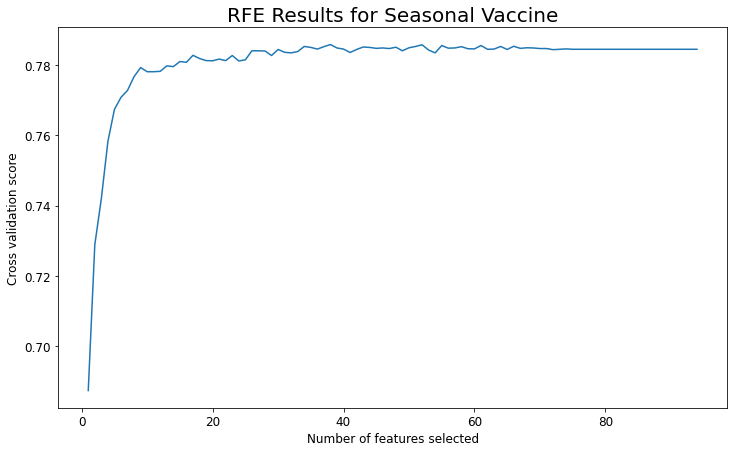

In [139]:
plt.figure(figsize=(12,7))
plt.title('RFE Results for Seasonal Vaccine', fontsize=20)
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, 95), selector.cv_results_['mean_test_score'])
plt.show()  

In [137]:
estimator2 = GradientBoostingClassifier(learning_rate=0.15, max_features='auto', min_samples_leaf=10, n_estimators=10000,
                           n_iter_no_change=20, random_state = 42)


selector2 = RFECV(estimator, step=1, cv=5)

selector2.fit(Xh_train, yh_train)

RFECV(cv=5,
      estimator=GradientBoostingClassifier(learning_rate=0.15,
                                           max_features='auto',
                                           min_samples_leaf=20,
                                           n_estimators=10000,
                                           n_iter_no_change=10,
                                           random_state=49))

In [140]:
selector2.n_features_

40

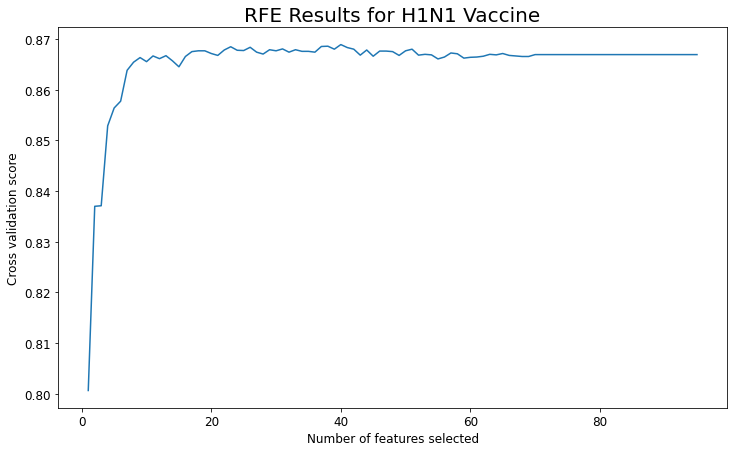

In [141]:
plt.figure(figsize=(12,7))
plt.title('RFE Results for H1N1 Vaccine', fontsize=20)
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, 96), selector2.cv_results_['mean_test_score'])
plt.show()

In [142]:
selector2.n_features_

40

In [143]:
seas_RFE = Xs.iloc[:,selector.support_]

In [144]:
h1n1_RFE = Xh.iloc[:,selector2.support_]

In [145]:
h1n1_RFE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   h1n1_concern                    26707 non-null  float64
 1   h1n1_knowledge                  26707 non-null  float64
 2   behavioral_antiviral_meds       26707 non-null  float64
 3   behavioral_face_mask            26707 non-null  float64
 4   doctor_recc_h1n1                26707 non-null  float64
 5   doctor_recc_seasonal            26707 non-null  float64
 6   child_under_6_months            26707 non-null  float64
 7   health_worker                   26707 non-null  float64
 8   opinion_h1n1_vacc_effective     26707 non-null  float64
 9   opinion_h1n1_risk               26707 non-null  float64
 10  opinion_h1n1_sick_from_vacc     26707 non-null  float64
 11  opinion_seas_vacc_effective     26707 non-null  float64
 12  opinion_seas_risk               

In [146]:
seas_RFE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   h1n1_concern                    26707 non-null  float64
 1   h1n1_knowledge                  26707 non-null  float64
 2   behavioral_touch_face           26707 non-null  float64
 3   doctor_recc_h1n1                26707 non-null  float64
 4   doctor_recc_seasonal            26707 non-null  float64
 5   chronic_med_condition           26707 non-null  float64
 6   health_worker                   26707 non-null  float64
 7   opinion_h1n1_vacc_effective     26707 non-null  float64
 8   opinion_h1n1_risk               26707 non-null  float64
 9   opinion_h1n1_sick_from_vacc     26707 non-null  float64
 10  opinion_seas_vacc_effective     26707 non-null  float64
 11  opinion_seas_risk               26707 non-null  float64
 12  opinion_seas_sick_from_vacc     

In [205]:
X2h_train, X2h_test, y2h_train, y2h_test = train_test_split(h1n1_RFE, yh, test_size=0.3, random_state=69)

In [206]:
%%time
gbc2h = GradientBoostingClassifier(learning_rate=0.075, loss='exponential', max_depth=6, random_state=49)
gbc2h.fit(X2h_train, y2h_train)


y2h_predict_gbc = gbc2h.predict(X2h_test)

gbc2_h_proba = gbc2h.predict_proba(X2h_test)

print(confusion_matrix(y2h_test, y2h_predict_gbc))

print(gbc2h.score(X2h_test,y2h_test))

[[5975  322]
 [ 717  999]]
0.8703357044802197
CPU times: user 4.07 s, sys: 49.6 ms, total: 4.12 s
Wall time: 4.16 s


In [211]:
cv_scores_test= cross_val_score(gbc2h,X2h_test,y2h_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc2h,X2h_train,y2h_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv2_rocauc_gbh_test= cv_scores_test.mean()
cv2_rocauc_gbh_train= cv_scores_train.mean()
cv2_rocauc_std_gbh= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv2_rocauc_gbh_test))
print ('Mean cross validation train score: ' +str(cv2_rocauc_gbh_train))
print ('Standard deviation in cv scores: ' +str(cv2_rocauc_std_gbh))

[0.88333102 0.87738442 0.88814258 0.88756406 0.89190134]
Mean cross validation test score: 0.8856646850971763
Mean cross validation train score: 0.8917897495212171
Standard deviation in cv scores: 0.004952821829007178


In [208]:
roc_auc_score(y2h_test, gbc2_h_proba[:,1])

0.8966169741538964

In [209]:
X2s_train, X2s_test, y2s_train, y2s_test = train_test_split(seas_RFE, ys, test_size=0.3, random_state=69)

In [210]:
%%time
gbc2s = GradientBoostingClassifier(learning_rate=0.2, random_state=49)
gbc2s.fit(X2s_train, y2s_train)


y2s_predict_gbc = gbc2s.predict(X2s_test)
gbc2_s_proba = gbc2s.predict_proba(X2s_test)

print(confusion_matrix(y2s_test, y2s_predict_gbc))

print(gbc2s.score(X2s_test,y2s_test))

[[3451  818]
 [ 897 2847]]
0.7859727942094097
CPU times: user 2.51 s, sys: 58.8 ms, total: 2.57 s
Wall time: 2.61 s


In [85]:
roc_auc_score(y2s_test, gbc2_s_proba[:,1])

0.8638078597341599

In [212]:
cv_scores_test= cross_val_score(gbc2s,X2s_test,y2s_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc2s,X2s_train,y2s_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv2_rocauc_gbs_test= cv_scores_test.mean()
cv2_rocauc_gbs_train= cv_scores_train.mean()
cv2_rocauc_std_gbs= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv2_rocauc_gbs_test))
print ('Mean cross validation train score: ' +str(cv2_rocauc_gbs_train))
print ('Standard deviation in cv scores: ' +str(cv2_rocauc_std_gbs))

[0.84908371 0.86049158 0.85605632 0.85068642 0.86481202]
Mean cross validation test score: 0.856226010509517
Mean cross validation train score: 0.8620345053092354
Standard deviation in cv scores: 0.00589309764652499


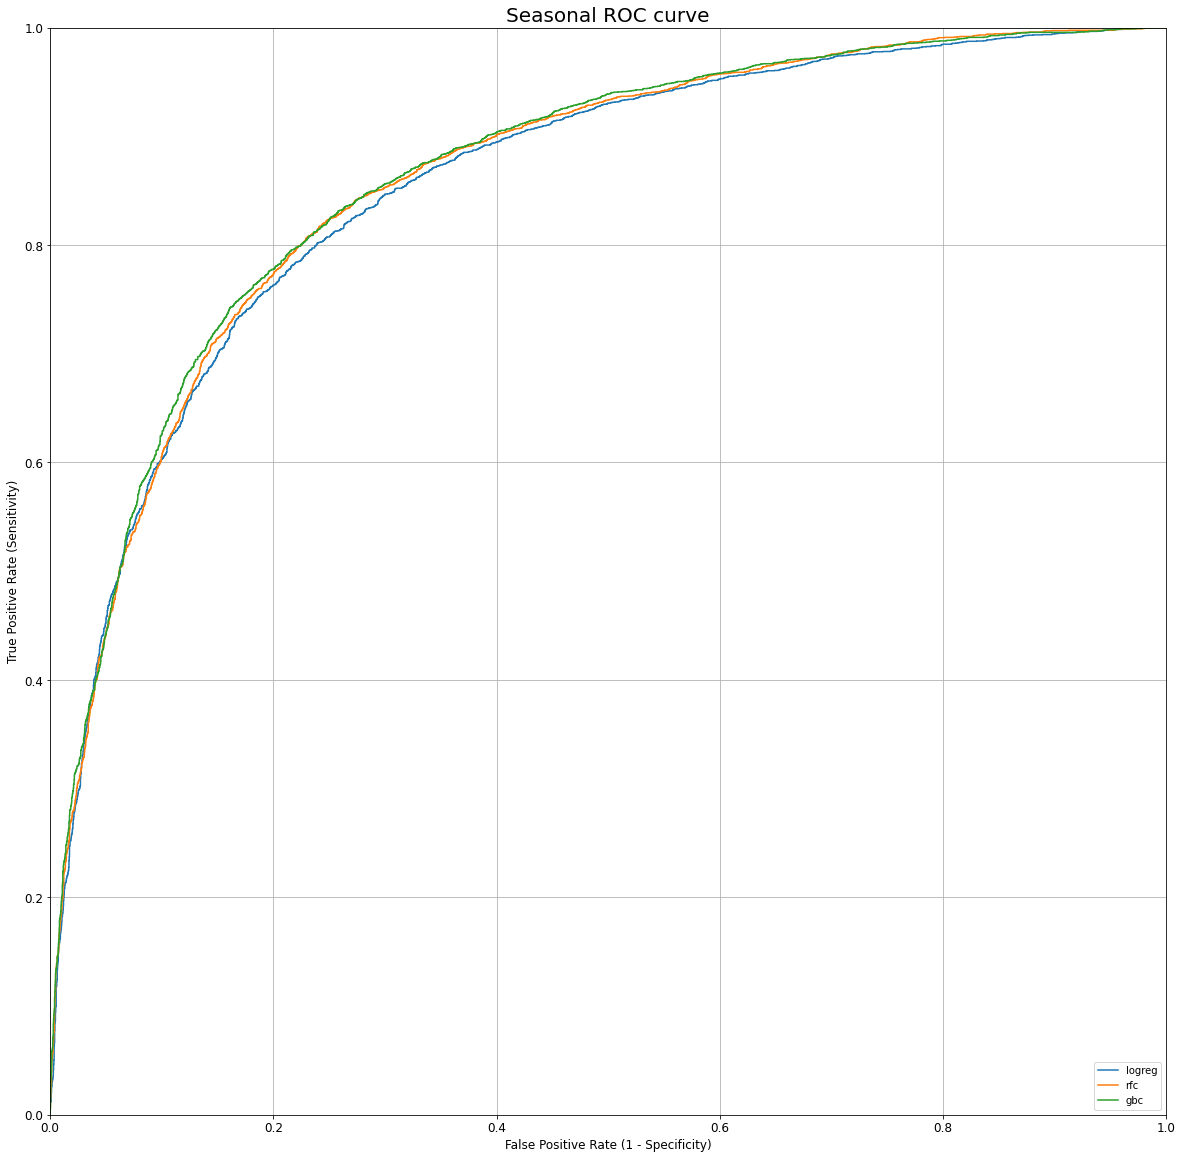

In [161]:
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y2s_test, lr_s_proba[:, 1])
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(ys_test, rfc_s_proba[:, 1])
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(ys_test, gbc_s_proba[:, 1])

plt.plot(fpr_logreg, tpr_logreg, label="logreg")
plt.plot(fpr_rfc, tpr_rfc, label="rfc")
plt.plot(fpr_gbc, tpr_gbc, label="gbc")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 20, 20
plt.title('Seasonal ROC curve', fontsize=20)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.savefig('./figures/Seas_ROC_AUC.pdf')

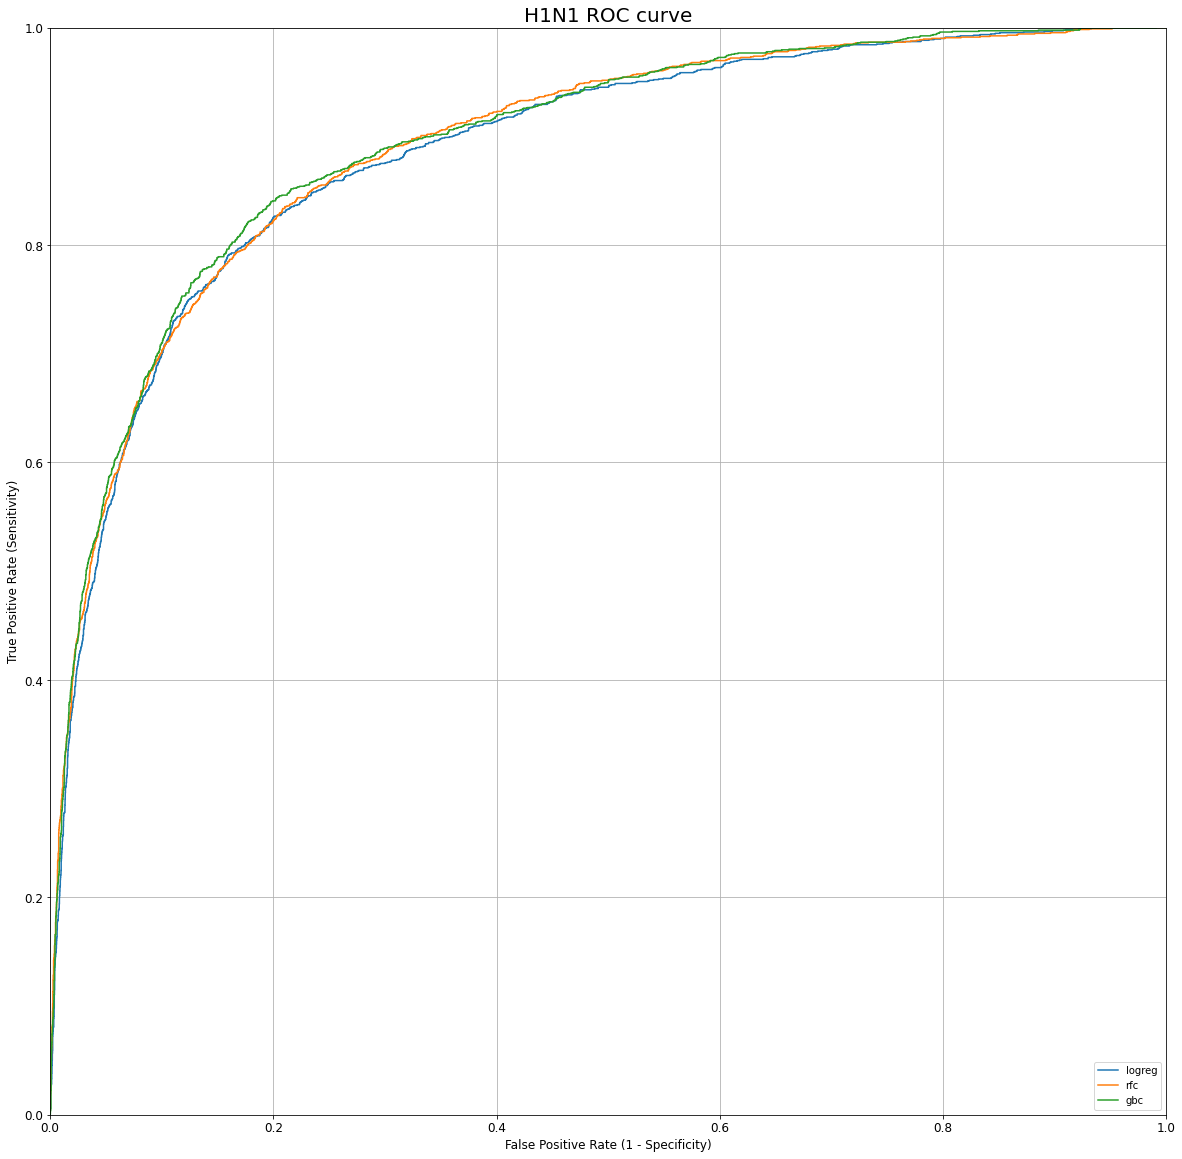

In [162]:
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y2h_test, lr_h_proba[:, 1])
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(yh_test, rfc_h_proba[:, 1])
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(yh_test, gbc_h_proba[:, 1])

plt.plot(fpr_logreg, tpr_logreg, label="logreg")
plt.plot(fpr_rfc, tpr_rfc, label="rfc")
plt.plot(fpr_gbc, tpr_gbc, label="gbc")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 20, 20
plt.title('H1N1 ROC curve', fontsize=20)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.savefig('./figures/H1N1_ROC_AUC.pdf')

# Final Predictions:

In [175]:
test_features = pd.read_csv('Data/ML_ready_test')

In [179]:
test = test_features.drop(columns=['respondent_id'])

## Seasonal Predictions:

In [180]:
# using entire train set for training we can make predictions for contest test set
gbc_final = GradientBoostingClassifier(learning_rate=0.15, max_features='auto',
                           min_samples_leaf=20, n_estimators=10000, n_iter_no_change=10)

gbc_final.fit(Xs, ys)

final_pred = gbc_final.predict(test)
final_proba = gbc_final.predict_proba(test)

In [209]:
final_df = test_features[['respondent_id']]

In [185]:
X_plus_seas = test
X_plus_seas['seasonal_vaccine'] = final_pred

In [192]:
X_plus_seas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 95 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   h1n1_concern                    26708 non-null  float64
 1   h1n1_knowledge                  26708 non-null  float64
 2   behavioral_antiviral_meds       26708 non-null  float64
 3   behavioral_avoidance            26708 non-null  float64
 4   behavioral_face_mask            26708 non-null  float64
 5   behavioral_wash_hands           26708 non-null  float64
 6   behavioral_large_gatherings     26708 non-null  float64
 7   behavioral_outside_home         26708 non-null  float64
 8   behavioral_touch_face           26708 non-null  float64
 9   doctor_recc_h1n1                26708 non-null  float64
 10  doctor_recc_seasonal            26708 non-null  float64
 11  chronic_med_condition           26708 non-null  float64
 12  child_under_6_months            

In [191]:
Xh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 95 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   h1n1_concern                    26707 non-null  float64
 1   h1n1_knowledge                  26707 non-null  float64
 2   behavioral_antiviral_meds       26707 non-null  float64
 3   behavioral_avoidance            26707 non-null  float64
 4   behavioral_face_mask            26707 non-null  float64
 5   behavioral_wash_hands           26707 non-null  float64
 6   behavioral_large_gatherings     26707 non-null  float64
 7   behavioral_outside_home         26707 non-null  float64
 8   behavioral_touch_face           26707 non-null  float64
 9   doctor_recc_h1n1                26707 non-null  float64
 10  doctor_recc_seasonal            26707 non-null  float64
 11  chronic_med_condition           26707 non-null  float64
 12  child_under_6_months            

## H1N1 Predictions:

In [198]:
gbc2_final = GradientBoostingClassifier(learning_rate=0.15, max_features='auto', min_samples_leaf=10, n_estimators=10000,
                           n_iter_no_change=20)

gbc2_final.fit(XH, yh)

final_proba_h = gbc2_final.predict_proba(X_plus_seas)

## Final Submission:

In [210]:
final_df['h1n1_vaccine'] = final_proba_h[:,1]
final_df['seasonal_vaccine'] = final_proba[:,1]

In [211]:
final_df.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.056234,0.315138
1,26708,0.022656,0.029818
2,26709,0.166744,0.684827
3,26710,0.690578,0.874436
4,26711,0.104013,0.467076


In [213]:
final_df.to_csv('final_submission.csv', index=False)